In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

import glob
import dask
import warnings
import cartopy
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import sys
sys.path.insert(0, "/user/work/eh19374/LPDM-emulation-trees_TESTING/")
from trees_emulator.load_data import *
from trees_emulator.training import *
from trees_emulator.predicting import *
from trees_emulator.marco_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# run this so loaded functions/packages get automatically updated if you edit
%load_ext autoreload
%autoreload 2

### Loading Datasets

In [3]:
# load the data for a particular site
domains = {"MHD":"EUROPE", "THD":"USA", "TAC":"EUROPE", "RGL":"EUROPE", "HFD":"EUROPE", "BSD":"EUROPE", "GSN":"EASTASIA"}
heights = {"MHD":"10magl", "THD":"10magl", "TAC":"185magl", "RGL":"90magl", "HFD":"100magl", "BSD":"250magl", "GSN":"10magl"} # default heights

## for UK/Ireland sites (MHD, TAC, RGL, BSD, HFD)
met_datadir = "/group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*"
extramet_datadir = "/group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*"


Select site

In [4]:
site = 'BSD'

In [5]:
fp_datadir = f"/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/{site}-{heights[site]}_UKV_EUROPE_*"
OG_2016 = LoadData(year="2016", site=site, size=10, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
coarse2_2016 = LoadData(year="2016", site=site, size=9, coarsen_factor=2, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
coarse3_2016 = LoadData(year="2016", site=site, size=12, coarsen_factor=3, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
coarse4_2016 = LoadData(year="2016", site=site, size=17, coarsen_factor=4, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
coarse5_2016 = LoadData(year="2016", site=site, size=22, coarsen_factor=5, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)

Loading Meteorology data from /group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*2016*.nc
Loading footprint data from /group/chemistry/acrg/LPDM/fp_NAME/EUROPE/BSD-250magl_UKV_EUROPE_*2016*.nc
Cutting data to size
Loading extra meteorology from /group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*2016*.nc and extracting gradients
Extracting wind vectors
All data loaded
Loading Meteorology data from /group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*2016*.nc
Loading footprint data from /group/chemistry/acrg/LPDM/fp_NAME/EUROPE/BSD-250magl_UKV_EUROPE_*2016*.nc
Cutting data to size
Loading extra meteorology from /group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*2016*.nc and extracting gradients
Extracting wind vectors
All data loaded
Loading Meteorology data from /group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*2016*.nc
Loading footprint data from /group/chemistry/acrg/LPDM/fp_NAME/EUROPE/BSD-250magl_UKV_EUROPE_*

### TRAINING ###

In [6]:
# change depending on site
trained_2 = import_coarsened_and_train('BSD_1415_coarsened2', coarse2_2016, [6], 14)
trained_3 = import_coarsened_and_train('BSD_1415_coarsened3', coarse3_2016, [6], 18)
trained_4 = import_coarsened_and_train('BSD_1415_coarsened4', coarse4_2016, [6], 22)
trained_5 = import_coarsened_and_train('BSD_1415_coarsened5', coarse5_2016, [6], 28)

Trained model info: {'site': 'BSD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 9}
Trained model info: {'site': 'BSD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 12}
Trained model info: {'site': 'BSD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 17}
Trained model info: {'site': 'BSD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 22}


### UNCOARSEN TO OG RESOLUTION ###

In [7]:
uncoarsened_predictions2, uncoarsened_fp_data2 = Uncoarsen(trained_2, coarse2_2016, OG_2016, 2)
uncoarsened_predictions3, uncoarsened_fp_data3 = Uncoarsen(trained_3, coarse3_2016, OG_2016, 3)
uncoarsened_predictions4, uncoarsened_fp_data4 = Uncoarsen(trained_4, coarse4_2016, OG_2016, 4)
uncoarsened_predictions5, uncoarsened_fp_data5 = Uncoarsen(trained_5, coarse5_2016, OG_2016, 5)

### COMBINE ALL INTO SINGLE ARRAY

In [8]:
uncoarsened_list_predictions = [uncoarsened_predictions2, uncoarsened_predictions3, uncoarsened_predictions4, uncoarsened_predictions5]

final, combined, OG = combine_all(uncoarsened_list_predictions, OG_2016, True)

In [9]:
uncoarsened_list_fp = [uncoarsened_fp_data2, uncoarsened_fp_data3, uncoarsened_fp_data4, uncoarsened_fp_data5]

final_fp, combined_fp, OG = combine_all(uncoarsened_list_fp, OG_2016, True)

### Trim to only predicted area

In [10]:
predicted_5x_data, OG_data, coarsened_fp_data = trim_coarsened_and_OG(combined, OG, combined_fp)

### Binarize Values

In [11]:
threshold = 0.0005
binary_data = binarize_array(predicted_5x_data, threshold).reshape((predicted_5x_data.shape[1]*predicted_5x_data.shape[2]), predicted_5x_data.shape[0])
binary_OG = binarize_array(OG_data, threshold).reshape((OG_data.shape[1]*OG_data.shape[2]), OG_data.shape[0])
binary_fp = binarize_array(coarsened_fp_data, threshold).reshape((coarsened_fp_data.shape[1]*coarsened_fp_data.shape[2]), coarsened_fp_data.shape[0])

### Intersection over Union & Dice Similarity

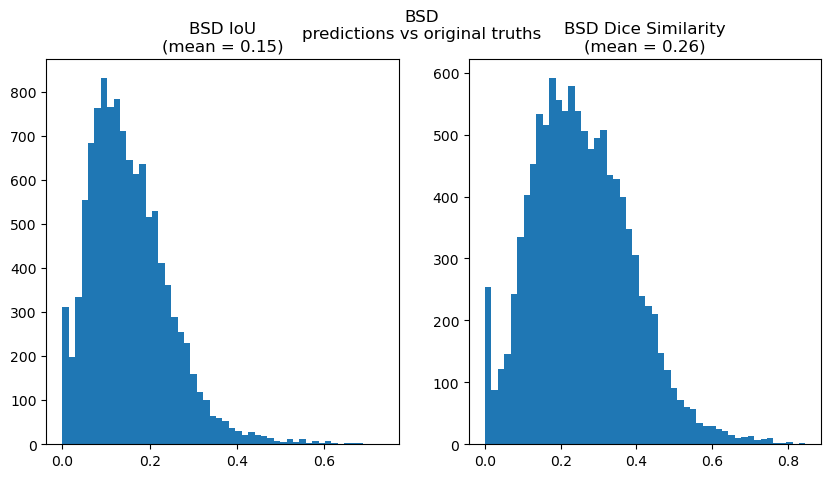

In [12]:
IoU = intersection_over_union(binary_data, binary_OG, zero=0)
dice = dice_similarity(binary_data, binary_OG, zero=0)
plot_IoU_dice(IoU, dice, 'BSD')

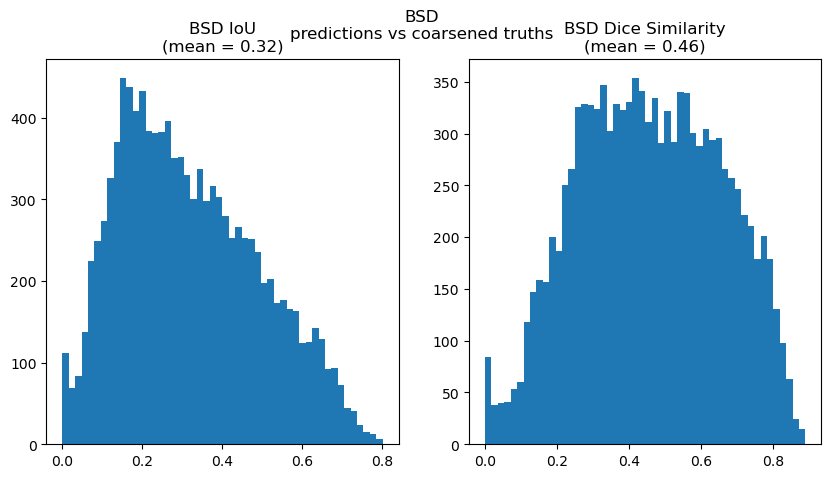

In [13]:
IoU_coarsened = intersection_over_union(binary_data, binary_fp, zero=0)
dice_coarsened = dice_similarity(binary_data, binary_fp, zero=0)
plot_IoU_dice(IoU_coarsened, dice_coarsened, 'BSD', True)

### Fluxes (R2, MAE, Bias)

In [14]:
predicted_fp, OG_data, coarsened_fp_data = trim_coarsened_and_OG(combined, OG, combined_fp, False)

In [15]:
predicted_fp_values = predicted_fp.data.reshape(predicted_fp.shape[0], (predicted_fp.shape[1]*predicted_fp.shape[2]))
OG_fp_values = OG_data.data.reshape(OG_data.shape[0], (OG_data.shape[1]*OG_data.shape[2]))

In [16]:
#  load fluxes
fluxes_og = xr.open_dataset("/group/chemistry/acrg/LPDM/emissions/EUROPE/ch4-EUROPE_"+str(2016)+"_EDGARv6.nc")
# cut to data
fluxes = fluxes_og.sel(lat=predicted_fp.lat, lon= predicted_fp.lon, method="nearest")
fluxes = fluxes.flux.values

In [17]:
true_fluxes_OG, pred_flux_OG = predict_fluxes(OG_data.data, predicted_fp.data, fluxes)
true_fluxes_coarse, pred_flux_coarse = predict_fluxes(coarsened_fp_data.data, predicted_fp.data, fluxes)

In [18]:
print(f"Site: {site}, vs Original")
print(f"R2 score: {r2_score(true_fluxes_OG, pred_flux_OG):.4f}")
print(f"MAE: {mean_absolute_error(true_fluxes_OG, pred_flux_OG):.2E}")
print(f"bias: {mean_bias(true_fluxes_OG, pred_flux_OG):.2E}")

Site: BSD, vs Original
R2 score: -3.6839
MAE: 1.98E-06
bias: -1.90E-06


In [19]:
print(f"Site: {site}, vs Coarsened")
print(f"R2 score: {r2_score(true_fluxes_coarse, pred_flux_coarse):.4f}")
print(f"MAE: {mean_absolute_error(true_fluxes_coarse, pred_flux_coarse):.2E}")
print(f"bias: {mean_bias(true_fluxes_coarse, pred_flux_coarse):.2E}")

Site: BSD, vs Coarsened
R2 score: 0.2665
MAE: 1.99E-06
bias: 6.28E-07


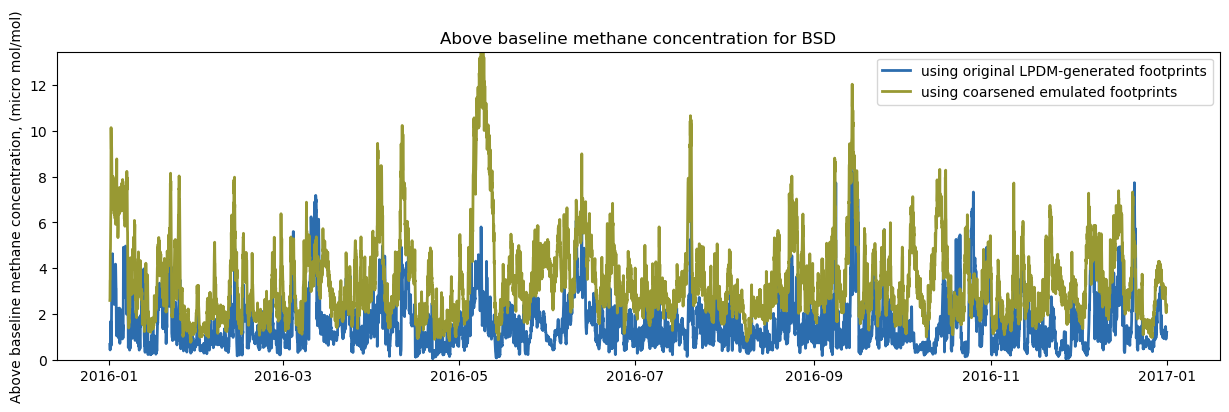

In [21]:
plot_fluxes(true_fluxes_OG, pred_flux_coarse, predicted_fp, 'BSD')

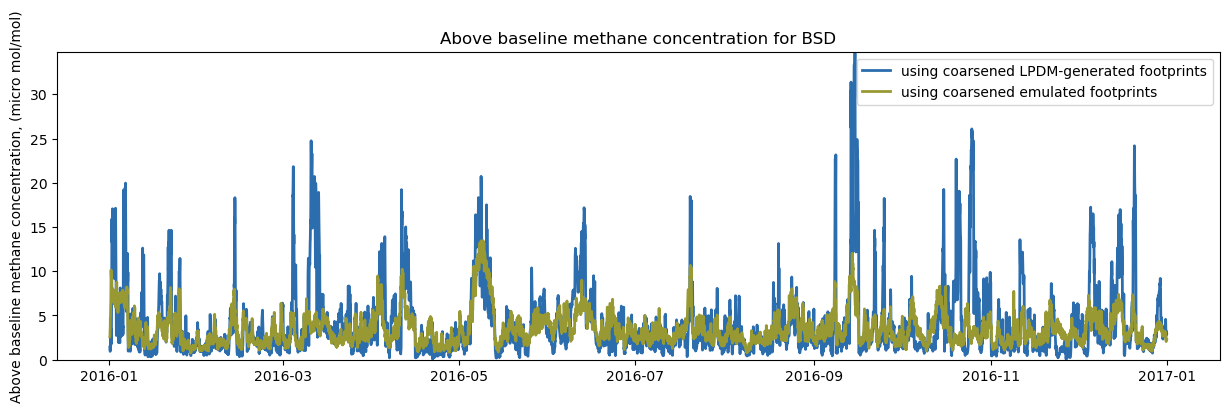

In [20]:
plot_fluxes(true_fluxes_coarse, pred_flux_coarse, predicted_fp, 'BSD', True)